## Clasificación. Árboles de decisión y K-vecinos más cercanos.

## Descripción del Problema

Con el deterioro de la calidad de los cuerpos de agua y cómo, con el machine learning, se puede apoyar la implementación de mecanismos que permitan monitorear y evaluar las variaciones en las características fisicoquímicas del agua, con el fin de preservar la calidad de estos ecosistemas y garantizar la disponibilidad de agua dulce para la población humana.

**A. Objetivos.**

- Aplicar técnicas de clasificación basadas en árboles de decisión y K-vecinos más cercanos para construir modelos predictivos que permitan estimar la calidad del agua de una zona determinada.

- Determinar cuáles son los factores que más inciden en la contaminación de los cuerpos de agua con base en los datos.

**B. Conjunto de datos.**

El conjunto de datos está relacionado con muestras de agua tomadas de diferentes fuentes, caracterizadas por variables fisicoquímicas y anotadas por los expertos, indicando cuáles son aptas para el consumo y cuáles no. 

**C. Actividades para realizar.**

1. Exploración y perfilamiento de los datos, utilizando las funcionalidades de la librería pandas. Recuerda que este paso es muy importante para determinar problemas de calidad (por ejemplo, valores ausentes y registros duplicados) y tomar decisiones relacionadas con la preparación de los datos para el algoritmo de aprendizaje. 

2. Limpieza y preparación de los datos, justificando las decisiones tomadas con base en los resultados obtenidos en el paso anterior.

3. Construcción de un modelo de árboles de decisión. Utiliza la función GridSeacrhCV, con el siguiente espacio de búsqueda: {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,12],'min_samples_split':[3, 4, 5]}. Además, utiliza la opción class_weight='balanced'.

4. Construcción de un modelo utilizando el algoritmo K-vecinos más cercanos. Para determinar el número de vecinos utiliza las técnicas de selección de modelos sobre los siguientes valores de K: [1, 2, 3, 4, 5].

5. Elaboración de una tabla comparativa mostrando el rendimiento sobre test de los dos modelos seleccionados (con mejores rendimientos) de las actividades 3 y 4, sobre las métricas exactitud, recall, precisión y F-score.

6. Utilizando el modelo de árboles de decisión con una profundidad de tres (3), genera las reglas que nos permiten determinar cuándo el agua no es apta para el consumo.


**D. Consideraciones.**

- En el conjunto de datos se utiliza el símbolo “?” para indicar una ausencia. Debes indicárselo a scikit-learn, ya que esta librería utiliza otros símbolos. Esta información la puedes especificar al cargar los datos de la siguiente manera:

```data=pd.read_csv('Datos_Etapa2.csv', sep=';', na_values=['?'], encoding = 'utf-8').```

Si el archivo está en formato excel, puedes utilizar la funcionalidad "read_excel" de pandas.

- Al hacer la división entrenamiento – test utiliza un valor de semilla de 77 (random_state).


**E. Análisis de resultados.**

Una vez construido los modelos, deberías estar en capacidad de responder estas preguntas:

- ¿Qué puedes decir de los valores de las métricas recall y precisión para cada una de las clases en cada modelo? ¿Cuál de estás métricas consideras que es más importante con base en la descripción del problema?

- ¿Consideras que el rendimiento de los modelos es adecuado? Si no es así, ¿Cómo podrían mejorarse los resultados?

- ¿Cuáles son las variables más significativas según el mejor modelo basado en árboles de decisión? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.

- Si los dos modelos proporcionan resultados similares en cuanto a las métricas de rendimiento ¿Cuál seleccionarías tomando en cuenta el contexto del problema?

## Solución

Iniciamos con la carga de las librería necesarias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings

In [2]:
warnings.simplefilter("ignore")

## Perfilamiento y exploración de los datos

In [6]:
raw_data = pd.read_excel("data/Datos_Etapa-2.xlsx", na_values=["?"])

# Ver los primeros 5 registros para comenzar a conocer los datos
raw_data.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,NO
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,NO
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,NO
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,NO
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,NO


In [7]:
# Tamaño de los datos
raw_data.shape

(3276, 10)

In [8]:
# Verificar el tipo de datos y la existencia o no de datos faltantes en cada columna
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                2785 non-null   float64
 1   Dureza            3276 non-null   float64
 2   Sólidos           3276 non-null   float64
 3   Cloraminas        3276 non-null   float64
 4   Sulfatos          2495 non-null   float64
 5   Conductividad     3276 non-null   float64
 6   Carbono_orgánico  3276 non-null   float64
 7   Trihalometanos    3114 non-null   float64
 8   Turbidez          3276 non-null   float64
 9   Potabilidad       3276 non-null   object 
dtypes: float64(9), object(1)
memory usage: 256.1+ KB


Con excepción de nuestra variable objetivo, todas las características son numéricas y a modo general representan la concentración de diferentes sólidos o iones disueltos en el agua. A continuación, procederemos a revisar si hay datos duplicados y datos nulos.

In [9]:
# Revisar si hay datos duplicados
raw_data.duplicated().sum()

np.int64(0)

In [10]:
# Contar exactamente cuántos datos nulos hay por columna
raw_data.isna().sum()

pH                  491
Dureza                0
Sólidos               0
Cloraminas            0
Sulfatos            781
Conductividad         0
Carbono_orgánico      0
Trihalometanos      162
Turbidez              0
Potabilidad           0
dtype: int64

No hay presencia de datos duplicados, pero sí de datos nulos (en las variables **pH, Sulfatos, Trihalometanos**) que necesitan ser solucionados antes de entrenar nuestros modelos de clasificación. En este caso se realizará imputación de valores.

Antes de la imputación, que haremos en la etapa de limpieza y preparación de datos, exploraremos algunas estadísticas importantes de cada variable, para entender su comportamiento.

## Resumen del Diccionario de los Datos

|Column Name | Type | Description|
|---|---|---|
| pH | numérico | Equilibrio ácido-base del agua. Rango de 0-14 |
| Dureza | numérico | Sales de calcio y magnesio. |
| Sólidos | numérico | Sólidos totales disueltos. Límite deseable = 500mg/l. Límite máximo para consumo = 1000mg/L |
| Cloraminas | numérico | Niveles de cloro y cloraminas presentes en el agua debido al tratamiento de la misma. Niveles seguros de cloro hasta 4mg/L o 4ppm |
| Sulfatos | numérico | Concentración de sulfato. Rango en suministros de agua dulce 3-30 mg/L. Algunas veces concentraciones más altas que 1000 mg/L |
| Conductividad | numérico | Conductividad Eléctrica (CE) - concentración de iones en solución. CE no debe superar los 400 μS/cm |
| Carbono Orgánico | numérico | Carbono Orgánico Total (COT) - Cantidad de carbonos en compuestos orgánicos en el agua pura |
| Trihalometanos | numérico | Niveles de hasta 80 ppm se consideran seguros en el agua potable. |
| Turbidez | numérico | Medida de la emisión de la luz. Se mide en NTU. La OMS recomienda un máximo de 5 NTU. |
| Apta | numérico | Indica si el agua es segura para consumo (SI/NO) |


In [11]:
# ¿Cuál es el rango de valores de cada variable?
raw_data.describe()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080804,196.369481,22014.092415,7.122241,333.775784,426.205171,14.284921,66.396281,3.966731
std,1.594369,32.879680,8768.570852,1.583143,41.416864,80.824123,3.308232,16.174983,0.780354
min,0.000000,47.430000,320.940000,0.350000,129.000000,181.480000,2.200000,0.740000,1.450000
25%,6.090000,176.847500,15666.687500,6.130000,307.695000,365.735000,12.070000,55.847500,3.440000
50%,7.040000,196.965000,20927.830000,7.130000,333.070000,421.885000,14.220000,66.620000,3.955000
75%,8.060000,216.670000,27332.760000,8.112500,359.950000,481.790000,16.560000,77.337500,4.500000
max,14.000000,323.120000,61227.200000,13.130000,481.030000,753.340000,28.300000,124.000000,6.740000


Algunas observaciones rápidas a partir de la tabla anterior:
- Los valores del **pH** se encuentran dentro del rango válido de [0, 14]. Además, su valor medio es 7.08 y se encuentra dentro del rango permisible recomendado por la OMS [6.5, 8.5]. Sin embargo, se ve un valor mínimo de 0, además el percentil 25 de 6.09 se encuentra por debajo del límite inferior.
- La concentración media de sólidos (22014mg/L) se encuentra muy por encima del límite máximo deseable (1000mg/L). Sin embargo, los valores parecen consistentes y válidos de acuerdo con los cuartiles.
- La concentración media de cloraminas (7.1 ppm) también está por encima del nivel seguro (4ppm); no obstante, aparentemente los valores máximos y mínimos generan un rango razonable.
- La concentración media de sulfatos se encuentra por encima del rango común en fuentes de agua dulce [3-30]mg/L; no obstante, el valore máximo (481) es inferior a valores observados en algunas ocasiones (+1000 mg/L)
- El nivel de conductividad medio se encuentra ligeramente por encima del nivel máximo recomendado.

**Estimar la variabilidad de cada atributo**

Un atributo con muy poca variabilidad no es útil para predicción. Para este paso, se usa el coeficiente de variación el cual es adimensional y se calcula como el cociente entre la desviación estándar y la media.

In [12]:
# Calculando el coeficiente de variación para determinar si alguna variable "varía" muy poco y por lo tanto no debiera ser usada.
raw_data.std(numeric_only=True) / raw_data.mean(numeric_only=True)

pH                  0.225168
Dureza              0.167438
Sólidos             0.398316
Cloraminas          0.222282
Sulfatos            0.124086
Conductividad       0.189637
Carbono_orgánico    0.231589
Trihalometanos      0.243613
Turbidez            0.196725
dtype: float64

Los coeficientes de los atributos se encuentran en el rango de 0.1 a 0.4, lo que indica alta variabilidad de estos.

### EDA

En esta sección se presentan algunas gráficas y valores estadísticos que nos permiten entender mejor las distribuciones de los datos y su relación con la variable objetivo (potabilidad del agua). Particulamente, iniciaremos con revisar el **balance de los datos**.

In [13]:
raw_data.Potabilidad.value_counts(normalize=True)

Potabilidad
NO    0.60989
SI    0.39011
Name: proportion, dtype: float64

Aunque el porcentaje de muestras de agua potable es menor a la no potable (40% a 60%), no se considera un desbalance fuerte de los datos.

**Correlación Entre Variables**

El objetivo de esta etapa es entender si hay variables fuertemente correlacionadas, de modos que pueda simplificarse la dimensionalidad.

In [14]:
correlation_matrix = raw_data.replace({"NO":False, "SI":True}).corr('pearson')
correlation_matrix

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
pH,1.000000,0.082086,-0.089271,-0.034247,0.018271,0.018606,0.043529,0.003446,-0.038985,-0.003555
Dureza,0.082086,1.000000,-0.046900,-0.030040,-0.106923,-0.023915,0.003601,-0.013015,-0.014487,-0.013835
Sólidos,-0.089271,-0.046900,1.000000,-0.070211,-0.171804,0.013831,0.010246,-0.009147,0.019551,0.033743
Cloraminas,-0.034247,-0.030040,-0.070211,1.000000,0.027307,-0.020465,-0.012678,0.017084,0.002334,0.023755
Sulfatos,0.018271,-0.106923,-0.171804,0.027307,1.000000,-0.016123,0.030830,-0.030276,-0.011155,-0.023577
Conductividad,0.018606,-0.023915,0.013831,-0.020465,-0.016123,1.000000,0.020965,0.001289,0.005694,-0.008128
Carbono_orgánico,0.043529,0.003601,0.010246,-0.012678,0.030830,0.020965,1.000000,-0.013296,-0.027342,-0.029985
Trihalometanos,0.003446,-0.013015,-0.009147,0.017084,-0.030276,0.001289,-0.013296,1.000000,-0.022224,0.007127
Turbidez,-0.038985,-0.014487,0.019551,0.002334,-0.011155,0.005694,-0.027342,-0.022224,1.000000,0.001562
Potabilidad,-0.003555,-0.013835,0.033743,0.023755,-0.023577,-0.008128,-0.029985,0.007127,0.001562,1.000000


Graficamos en un mapa de calor para facilidad de visualización

<Axes: >

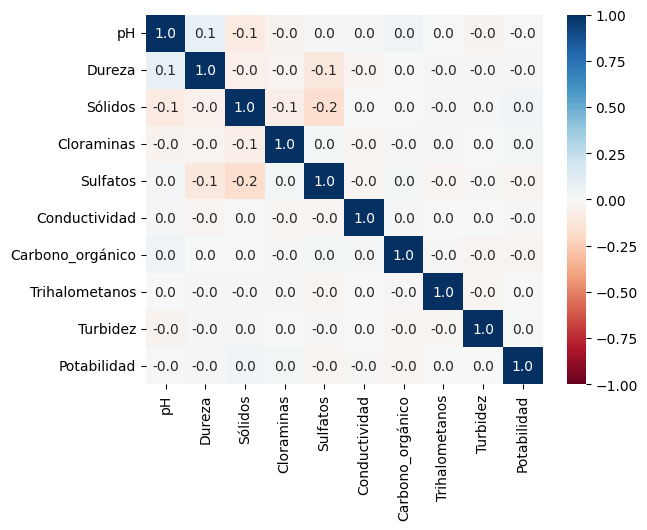

In [15]:
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="RdBu", vmin=-1, vmax=1)

La correlación de **Pearson** no muestra correlación lineal fuerte (positiva o negativa entre ninguna de las variables), pues el valor absoluto más grande es ~0.2. En caso de alta colinealidad, coeficiente de Pearson ~ > 0.9, algunas de las variables correlacionadas podrían eliminarse, simplificando el modelo para la etapa de entrenamiento del modelo. Esto potencialmente mejoraría la interpretabilidad del modelo.

A continuación, se observan las distribuciones de cada una de las variables, además de gráficos de dispersión para observar el comportamiento de relación en parejas de variables (**Análisis univariado y bivariado**).

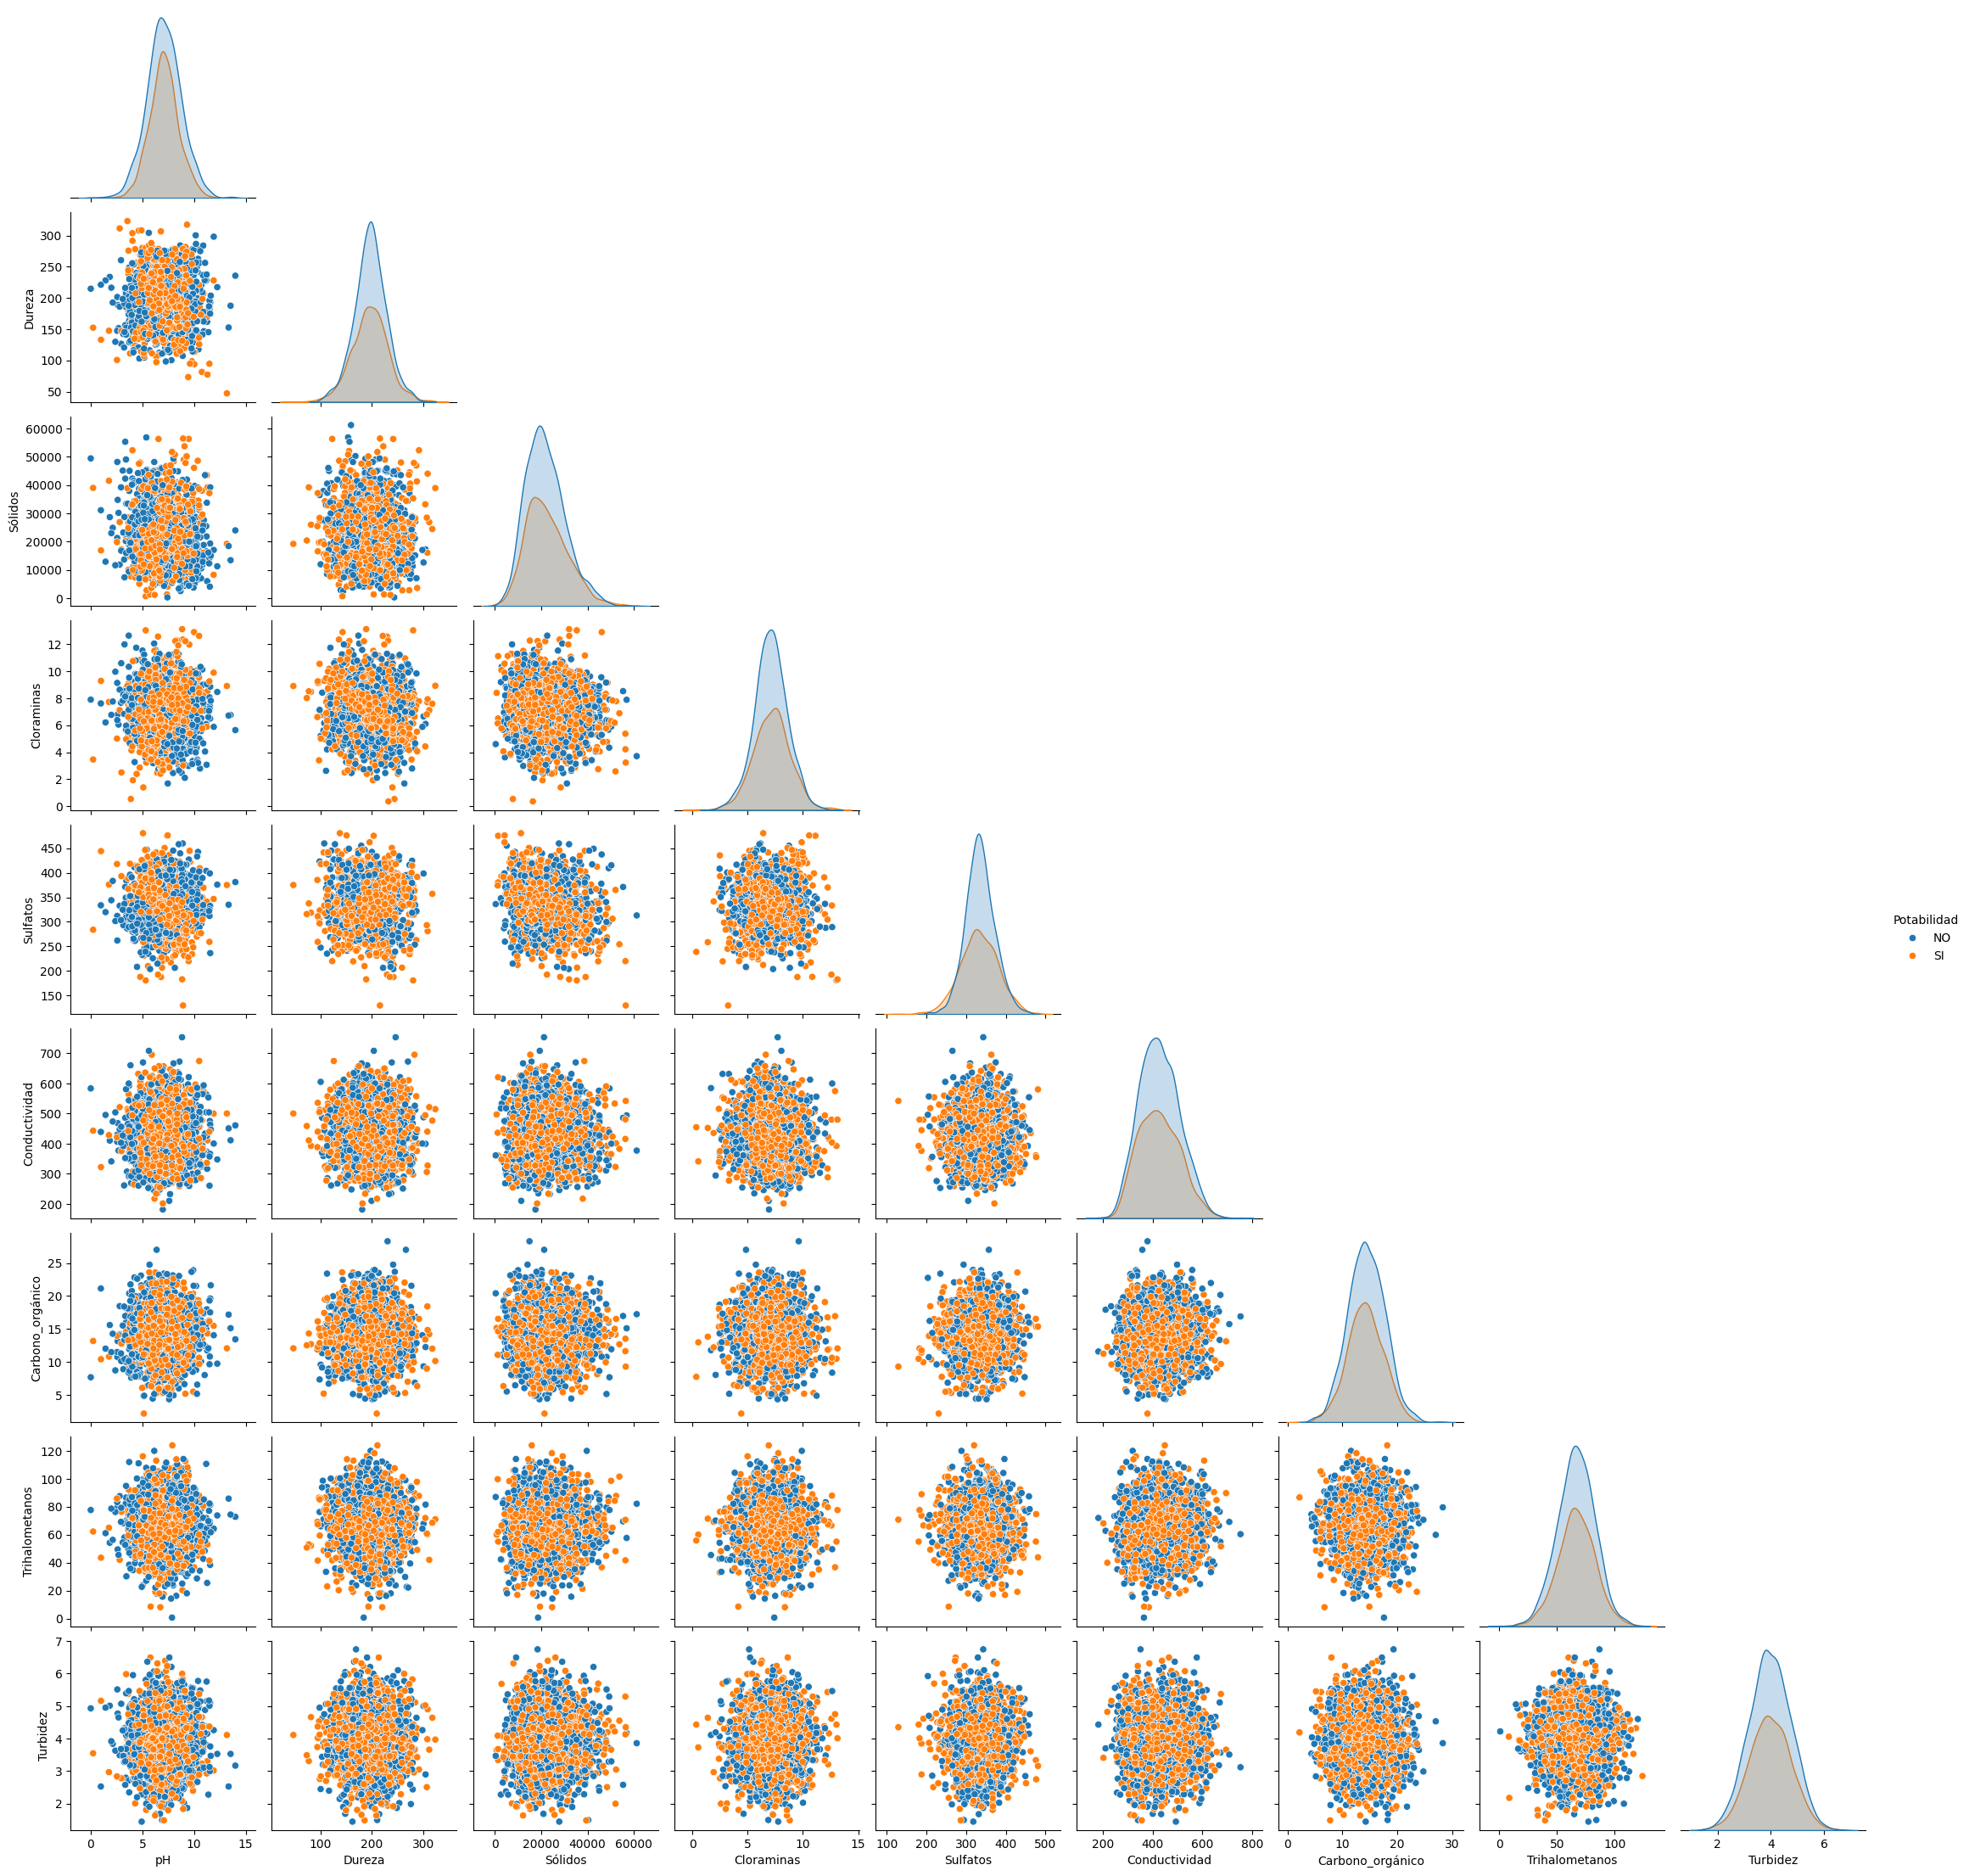

In [16]:
sns.pairplot(raw_data, corner=True, hue="Potabilidad")

Observaciones:
- Las distribuciones de las variables, graficadas en la diagonal del diagrama, muestran que todas las variables tiene una distribución con forma de campana (similar a una distribución normal). Tanto para el caso de datos etiquetados como <span style='color:orange; font-weight:bold'> potable </span> como no potable <span style='color:blue; font-weight:bold'> no potable </span>.
- Al observar los gráficos de dispersión no se observan correlaciones o tendencias claras entre las variables.
- Adicionalmente, aunque pueden observarse algunos outliers, no se caracteriza por tener outliers fuertes.
    - No eliminaré outliers, el algoritmo de árboles de decisión no es susceptible a estos. Por otro lado, para el KNN, se probará con varios tipos de escaladores en la etapa de búsqueda de los mejores hiperparámetros. Incluyendo ``RobustScaler``.

Estas observaciones revalidan lo mostrado anteriormente con los coeficientes de correlación. En conclusión, se utilizarán todas las variables para entrenar el modelo. Adicionalmente, los datos necesitan ser escalados para el modelo de KNN, de modos que todos los atributos estén en un rango comparable.

## Limpieza de los datos

A partir de esta sección se realizarán transformaciones a los datos, de modo que haremos una copia para preservar los originales en caso de necesitarlos.

In [17]:
data = raw_data.copy()

De la etapa anterior no se observaron datos duplicados. Sin embargo, sí hay presencia de datos nulos 

In [18]:
data.isna().sum()

pH                  491
Dureza                0
Sólidos               0
Cloraminas            0
Sulfatos            781
Conductividad         0
Carbono_orgánico      0
Trihalometanos      162
Turbidez              0
Potabilidad           0
dtype: int64

Probaremos la imputación con estrategias "mean" y "median" para calcular los datos faltantes. Esto se añadirá directamente a la pipeline de procesamiento.

Procedemos a preparar cada uno de los pasos del pipeline

In [19]:
# Determinar las variables numéricas para pasar al imputador
numeric_features = [
    i for i, col in enumerate(data.columns) 
    if (data.dtypes[col]==np.dtype('int64'))
    or (data.dtypes[col]==np.dtype('float64'))
]

print(f"Variables numéricas:\n{list(zip(numeric_features, data.columns.take(numeric_features)))}")

Variables numéricas:
[(0, 'pH'), (1, 'Dureza'), (2, 'Sólidos'), (3, 'Cloraminas'), (4, 'Sulfatos'), (5, 'Conductividad'), (6, 'Carbono_orgánico'), (7, 'Trihalometanos'), (8, 'Turbidez')]


No hay variables categóricas entre los predictores, así que el imputador constará de un solo elemento

In [20]:
num_imputer = SimpleImputer(strategy="mean")

In [21]:
imputer = ColumnTransformer(
    transformers=[
        ("num", num_imputer, numeric_features),
    ]
)

**Estandarización de las variables**

1. Debido a que todas las variables son numéricas, se someterán a un proceso de escalamiento para llevarlas a una escala comparable, de modo que favorezca el desempeño de los algoritmos. Este paso es particularmente *importante para algoritmos como la regresión logística que usa optimización por descenso de gradiente, o el k-vecinos por basarse en distancias*.

2. Para el caso de los *árboles de decisión no es importante*, ya que ellos no necesitan este preprocesamiento, es más, aplicarlo dificulta la interpretabilidad posterior de los resultados.

In [22]:
rob_scaler = RobustScaler()

El paso de imputación cambia el orden de las columnas. En este notebook no se observa el efecto puesto que todos los predictores son numéricos; sin embargo, si hubieran variables categóricas, entonces sería necesario definir el nuevo órden de las variables.

In [23]:
numeric_features2 = list(range(len(numeric_features)))

scaler = ColumnTransformer(
    transformers=[
        ("num", rob_scaler, numeric_features2),
    ],
    # remainder='passthrough'
)

**División de datos**

In [24]:
# División del conjunto de datos usando una razón de 4:1 entre el conjunto de entrenamiento y el de prueba

train, test = train_test_split(data, train_size=0.8, random_state=77)
print("Tamaño del conjunto de entrenamiento: ", train.shape)
print("Tamaño del conjunto de prueba: ", test.shape)

Tamaño del conjunto de entrenamiento:  (2620, 10)
Tamaño del conjunto de prueba:  (656, 10)


In [25]:
train.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
3126,6.67,155.71,30610.05,8.17,337.17,425.69,15.10,79.78,4.90,SI
3147,6.26,130.37,9734.68,10.28,320.36,399.35,10.85,43.42,3.93,SI
2844,6.66,182.39,16828.88,7.07,355.90,434.66,16.62,69.41,3.97,SI
1916,8.02,255.26,30854.83,8.76,NaN,442.50,11.09,93.27,5.32,SI
1053,8.92,207.52,13291.92,8.56,357.94,468.54,15.69,107.28,4.08,NO


In [26]:
# Dividir las variables predictoras de la objetivo
x_train = train.drop(columns="Potabilidad")
y_train = train.Potabilidad

print(f"Tamaño de X de entrenamiento = {x_train.shape}")
print(f"Tamaño de y de entrenamiento = {y_train.shape}")

Tamaño de X de entrenamiento = (2620, 9)
Tamaño de y de entrenamiento = (2620,)


In [27]:
x_test = test.drop("Potabilidad", axis=1)
y_test = test.Potabilidad

print(f"Tamaño de X de prueba = {x_test.shape}")
print(f"Tamaño de y de prueba = {y_test.shape}")

Tamaño de X de prueba = (656, 9)
Tamaño de y de prueba = (656,)


In [28]:
columns = x_train.columns

## Regresión Logística Simple
Primero crearé un modelo base basado en la regresión logística para comparación con los modelos más avanzados.

Crearé una pipeline simple usando la función ``make_pipeline``. Los pasos a incluir son:
- Un imputador simple usando estrategia **media**, la cual es la opción por defecto.
- Normalización por estandarización (transforma los datos a una distribución con media cero y desviación estándar unitaria).
- Finalmente, el algoritmo de regresión logística con random_state=0 y balanceo de clases.

In [29]:
log_reg_pipeline = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    LogisticRegression(random_state=0, class_weight='balanced')
)

Los pipelines permiten ejecutar todos los pasos directamente usando el método **fit**.

In [30]:
log_reg_pipeline.fit(x_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=0))])

La predicción es igual de sencilla, usando el método **predict**.

In [31]:
y_pred1 = log_reg_pipeline.predict(x_test)

In [32]:
# Listar los primeros 5 datos del conjunto de prueba. Permite comparar el resultado real y el predicho
pd.DataFrame({"test": y_test, "pred": y_pred1}).head()

,test,pred
2133,NO,SI
761,SI,SI
2269,NO,NO
807,SI,SI
2044,SI,NO


Graficaremos la matriz de confusión en un mapa de calor para facilitar su visualización y en la celda inmediatamente siguiente, se utiliza la función de ``classification_report`` para ver las métricas de desempeño.

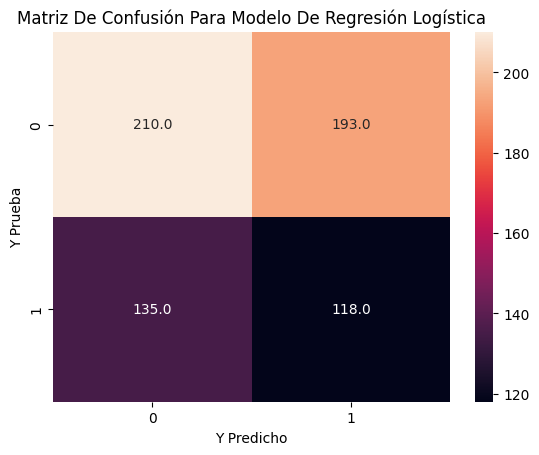

In [33]:
plt.figure()
hm1 = sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt=".1f")
hm1.set_title("Matriz de confusión para modelo de regresión logística".title())
hm1.set_xlabel("Y Predicho")
hm1.set_ylabel("Y Prueba")
plt.show()

El modelo muestra un **accuracy** global de 0.5. Es decir que el 50% de los datos los predice bien.

Las métricas de precisión y recall muestran que el modelo predice mejor la clase negativa que la positiva.

In [34]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

          NO       0.61      0.52      0.56       403
          SI       0.38      0.47      0.42       253

    accuracy                           0.50       656
   macro avg       0.49      0.49      0.49       656
weighted avg       0.52      0.50      0.51       656



Quise comprobar cómo se comportaría el algoritmo de regresión logística sin usar el parámetro de balanceo de clase. El resultado se presenta debajo. Se observa que el modelo deja de predecir completamente la clase positiva.

In [103]:
# print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

          NO       0.61      1.00      0.76       403
          SI       0.00      0.00      0.00       253

    accuracy                           0.61       656
   macro avg       0.31      0.50      0.38       656
weighted avg       0.38      0.61      0.47       656



A continuación, probaremos con dos modelos más: **árboles de decisión** y **KNN**.

## Árbol de Decisión

**Búsqueda de hiperparámetros para el algoritmo de árboles de decisión**

- Estrategia de imputación (variables numéricas): utilizaremos ``la media y la mediana``.
- criterion: el criterio de pureza, que determina la calidad de una división. Utilizaremos dos de los más populares: ``la entropía y GINI``.
- max_depth: la profundidad máxima del árbol. Este hiperparámetro se utiliza para el control de la complejidad del modelo.
- min_samples_split: número mínimo de datos necesarios en un nodo para poder definir una división.
- Además el algoritmo llevará el parámetro class_weight='balanced'

In [35]:
# Lo único que se usará en el pipeline es un imputador
decision_tree = DecisionTreeClassifier(random_state=77, class_weight='balanced')

In [36]:
# El algoritmo de árboles de decisión no requiere escalar los datos. Así este paso no se añade a la pipeline.
tree_steps = [
    ("imputer", imputer),
    ("model", decision_tree),
]

In [40]:
# Creamos el pipeline con los pasos definidos anteriormente
tree_pipeline = Pipeline(steps=tree_steps)

Se define el espacio de modelos a probar (los diferentes valores que puede tomar cada uno de los hiperparámetros).

In [37]:
tree_param_grid = {
    # Probar las estrategias de imputación
    'imputer__num__strategy': ['mean', 'median'],
    # hiperparámetros del algoritmo
    'model__criterion':['gini', 'entropy'],
    'model__max_depth':[4,6,8,10,12],
    'model__min_samples_split':[3, 4, 5],
}

Se realiza validación cruzada con 5 folds.

In [38]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=77)

Finalmente, se usa la clase GridSearch para probar todas las combinaciones y encontrar el mejor modelo.

In [41]:
grid = GridSearchCV(
    tree_pipeline,
    tree_param_grid,
    cv=kfolds,
)

Ejecutamos el grid search para obtener el mejor modelo

In [42]:
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=77))]),
             param_grid={'imputer__num__strategy': ['mean', 'median'],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [4, 6, 8, 10, 12],
                         'model__min_samples_split': [3, 4, 5]})

In [43]:
print("Mejores parámetros del árbol de decisión: {}".format(grid.best_params_))

Mejores parámetros del árbol de decisión: {'imputer__num__strategy': 'mean', 'model__criterion': 'gini', 'model__max_depth': 8, 'model__min_samples_split': 5}


El mejor resultado se obtuvo al imputar los datos con **la media**, y entrenando el modelo con el criterio **'Gini'**, máxima **profundidad de 8** y un **mínimo de 5 datos** para realizar una división de un nodo.

In [44]:
best_tree = grid.best_estimator_

Usamos el mejor árbol para generar la predicción de los datos de prueba. Nótese que se aplica el método predict directamente sobre los datos x_test sin pre-procesar. Esta etapa se encuentra embebida dentro del objeto best_tree.

In [45]:
tree_y_pred = best_tree.predict(x_test)

Ahora se visualiza la matriz de confusión por medio de un mapa de calor:

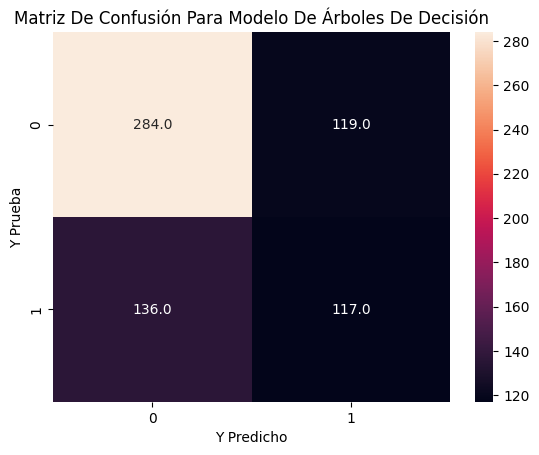

In [46]:
plt.figure()
hm2 = sns.heatmap(confusion_matrix(y_test, tree_y_pred), annot=True, fmt=".1f")
hm2.set_title("Matriz de confusión para modelo de árboles de decisión".title())
hm2.set_xlabel("Y Predicho")
hm2.set_ylabel("Y Prueba")
plt.show()

Este modelo muestra una mejora significativa con respecto al modelo base de regresión logística, especialmente se reducen la cantidad de falsos positivos (de 192 a 119). A continuación, analizaremos las métricas usando la función ``classification_report``.

In [47]:
print(classification_report(y_test, tree_y_pred))

              precision    recall  f1-score   support

          NO       0.68      0.70      0.69       403
          SI       0.50      0.46      0.48       253

    accuracy                           0.61       656
   macro avg       0.59      0.58      0.58       656
weighted avg       0.61      0.61      0.61       656



El modelo entrenado con árboles de decisión tiene una precisión global de 0.61, mejor que nuestro modelo base. Así mismo,  todas las métricas de precisión, recall, f1-score, y support son mejores para ambas clases.

- Similar al modelo base, el mejor modelo tipo árbol tiene mayor desempeño prediciendo la clase negativa "NO", es decir, cuando el agua no es potable.

Finalmente, construiremos un modelo KNN.

## K-Vecinos Más Cercanos

**Búsqueda de hiperparámetros para el algoritmo de K Vecinos**

- Estrategia de imputación (variables numéricas): utilizaremos la media y la mediana.
- Escalamiento: KNN calcula distancias entre todos los puntos, de modo que es necesario realizar un escalamiento de las variables para evitar que algunas tengan más peso únicamente debido a la magnitud de sus mediciones. Se probarán dos tipos de escaladores, uno por estandarización y otro por min_max.
- K: [1, 2, 3, 4, 5]

Definimos los valores de K usando la funcionalidad de numpy

In [48]:
k_values = np.linspace(1, 5, 5, dtype='int32').tolist()

Definimos los pasos que componen el pipeline y se instancia un objeto.

In [49]:
steps = [
    ("imputer", imputer),
    ("scaler", scaler),
    ("model", KNeighborsClassifier()),
]

k_pipeline = Pipeline(steps)

Se define el espacio de hiperparámetros a evaluar con el método de Grid Search.

In [50]:
k_param_grid = {
    "imputer__num__strategy": ["mean", "median"],
    "scaler__num": [StandardScaler(), MinMaxScaler(), RobustScaler()],
    "model__n_neighbors": k_values,
}

Usar GridSearch para probar todas las combinaciones y encontrar el mejor modelo.

In [51]:
kgrid = GridSearchCV(
    k_pipeline,
    k_param_grid,
    cv=kfolds,
)

Realizamos el entrenamiento del modelo

In [52]:
kgrid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('scaler',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'imputer__num__strategy': ['mean', 'median'],
                         'model__n_neighbors': [1, 2, 3, 4, 5],
                         'scaler__num': [StandardScaler(), MinMaxScaler(),
                                         RobustScaler()]})

In [53]:
print("Mejores parámetros de K vecinos: {}".format(kgrid.best_params_))

Mejores parámetros de K vecinos: {'imputer__num__strategy': 'median', 'model__n_neighbors': 4, 'scaler__num': RobustScaler()}


El mejor resultado se obtuvo al imputar los datos con la **mediana**, **n_neighbors** = 4, y escalamiento con **RobustScaler**.

In [54]:
best_knn = kgrid.best_estimator_

Usamos el mejor modelo KNN para generar la predicción de los datos de prueba. Nótese que se aplica el método predict directamente sobre los datos x_test sin pre-procesar. Esta etapa se encuentra embebida dentro del pipeline.

In [55]:
knn_y_pred = best_knn.predict(x_test)

Ahora se visualiza la matriz de confusión por medio de un mapa de calor:

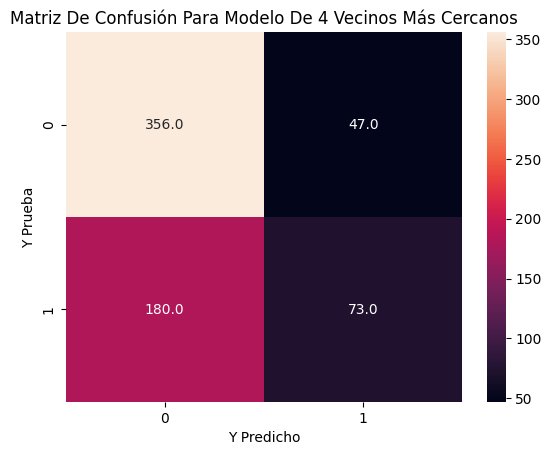

In [56]:
plt.figure()
hm3 = sns.heatmap(confusion_matrix(y_test, knn_y_pred), annot=True, fmt=".1f")
hm3.set_title("Matriz de confusión para modelo de 4 vecinos más cercanos".title())
hm3.set_xlabel("Y Predicho")
hm3.set_ylabel("Y Prueba")
plt.show()

La matriz de confusión muestra que este modelo también es mejor en predecir la clase negativa (agua no potable). Incluso la cantidad de falsos positivos se redujo considerablemente.

In [57]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

          NO       0.66      0.88      0.76       403
          SI       0.61      0.29      0.39       253

    accuracy                           0.65       656
   macro avg       0.64      0.59      0.57       656
weighted avg       0.64      0.65      0.62       656



- Este modelo tiene un ``accuracy`` global de 0.65.
- Es destacable el recall que tiene con la clase negativa. Un recall de 0.88 indica que el 88% de los datos que clasifica como negativos son en realidad negativos.
    - Es evidente que este modelo predice mejor la clase negativa. El f1-score de la clase NO es algo más del doble de la clase SI.

## Presentación de resultados

5. Elaboración de una tabla comparativa mostrando el rendimiento sobre test de los dos modelos seleccionados (con mejores rendimientos) de las actividades 3 y 4, sobre las métricas exactitud, recall, precisión y F-score.

In [120]:
print("Mejores parámetros del árbol de decisión: {}".format(grid.best_params_))

Mejores parámetros del árbol de decisión: {'imputer__num__strategy': 'mean', 'model__criterion': 'gini', 'model__max_depth': 8, 'model__min_samples_split': 5}


El mejor resultado se obtuvo al imputar los datos con **la media**, y entrenando el modelo con el criterio **'Gini'**, máxima **profundidad de 8** y un **mínimo de 5 datos** para realizar una división de un nodo.

In [122]:
print("Mejores parámetros de K vecinos: {}".format(kgrid.best_params_))

Mejores parámetros de K vecinos: {'imputer__num__strategy': 'median', 'model__n_neighbors': 4, 'scaler__num': RobustScaler()}


El mejor resultado se obtuvo al imputar los datos con la **mediana**, **n_neighbors** = 4, y escalamiento de los datos con **RobustScaler**.

In [ ]:
print("A continuación, se presentan las métricas para la clase positiva ('SI')")

tree_accurary = accuracy_score(y_test, tree_y_pred)
tree_precision = precision_score(y_test, tree_y_pred, pos_label='SI')
tree_recall = recall_score(y_test, tree_y_pred, pos_label='SI')
tree_f1_score = f1_score(y_test, tree_y_pred, pos_label='SI')

knn_accurary = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred, pos_label='SI')
knn_recall = recall_score(y_test, knn_y_pred, pos_label='SI')
knn_f1_score = f1_score(y_test, knn_y_pred, pos_label='SI')


In [131]:
pd.DataFrame({"Accuracy": [tree_accurary, knn_accurary], "Precision - SI": [tree_precision, knn_precision], "Recall - SI": [tree_recall, knn_recall], "F1 Score - SI": [tree_f1_score, knn_f1_score]}, index=["Decision Tree", "KNN"])

,Accuracy,Precision - SI,Recall - SI,F1 Score - SI
Decision Tree,0.611280,0.495763,0.462451,0.478528
KNN,0.653963,0.608333,0.288538,0.391421


Los resultados indican que el modelo de KNN tuvo mejor **Accuracy** global.

Con respecto al desempeño de ambos modelos para predecir la clase 1 ("SI" - <span style='color:orange; font-weight:bold'> El agua sí es potable  </span>), se puede decir que:
- El modelo de KNN tiene una **precisión** mayor, casi +0.1 (de 0.6 vs 0.5 del árbol de regresión). Es decir, que el 60% de los datos que predice como agua potable son en efecto potable.
- Con respecto al **recall** (definido como el % de los datos de una clase particular que fueron correctamente clasificados), se puede decir que:
    - El modelo de árbol tiene un puntaje mucho mayor que KNN (0.46 a 0.29).
- Con respecto al **f1-score**, definido como una combinación de precisión y recall, se observa que:
    - El algoritmo de árboles de decisión tiene un mejor desempeño para la clase 1 "SI".

**Si analizamos las métricas para la clase negativa (NO potable)** se observa que:

| Modelo | Clase | Precision | Recall | F1-Score |
|---|---|---|---|---|
|Tree| NO | 0.68 | 0.70 | 0.69 |
| KNN | NO | 0.66 | 0.88 | 0.76 |

El comportamiento de las métricas es al contrario de los obtenidos para la clase positiva.
- **Precisión**: El árbol de decisión tiene un desempeño ligeramente superior (+0.02).
- **Recall**: KNN es significativamente mejor.
- **F1-Score**: KNN también es mejor en esta métrica.

En conclusión:
- Ambos modelos predicen mejor la clase negativa.
- KNN es mejor en **accuracy** global y en **predecir la clase negativa - "No potable"**.
- El modelo de DecisionTree se comporta mejor que KNN para predecir la **clase positiva - "Potable"**.

6. Utilizando el modelo de árboles de decisión con una profundidad de tres (3), genera las reglas que nos permiten determinar cuándo el agua no es apta para el consumo.

In [138]:
# Utilizo los demás hiperparámetros encontrados en la etapa anterior.

decision_tree = DecisionTreeClassifier(random_state=77, class_weight='balanced', criterion="gini", max_depth=3, min_samples_split=5)

final_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    decision_tree
)

In [140]:
final_pipeline.fit(x_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                                        min_samples_split=5,
                                        random_state=77))])

A continuación, se extraen los pesos o importancias que el árbol de decisión asignpo a cada una de las variables predictoras.

In [151]:
final_model = final_pipeline["decisiontreeclassifier"]
importancia = final_model.feature_importances_
importancia

array([0.4976823 , 0.12460839, 0.        , 0.08280353, 0.29490578,
       0.        , 0.        , 0.        , 0.        ])

Crearemos una tabla con los nombres de las columnas para facilitar la interpretación de los números anteriores.

In [154]:
importancia_df = pd.DataFrame(data={'Variable':columns, 'Importancia':importancia})
importancia_df.sort_values('Importancia', ascending=False)

,Variable,Importancia
0,pH,0.497682
4,Sulfatos,0.294906
1,Dureza,0.124608
3,Cloraminas,0.082804
2,Sólidos,0.000000
5,Conductividad,0.000000
6,Carbono_orgánico,0.000000
7,Trihalometanos,0.000000
8,Turbidez,0.000000


Los resultados muestran que:
- La variable más importante para el modelo es el pH, representando el ~50% de la importancia.
- Seguido de las concentraciones de sulfatos (29%), dureza (12%) y Cloraminas (8%).
- Por otra parte, las variables ``Sólidos, COnductividad, Carbono Orgánico, Trihalometanos, y Turbidez`` no tuvieron importancia en el modelo.

Seguidamente, se usa la funcionalidad de ``plot_tree`` para visualizar el árbol construido y la selección de variables realizadas por el modelo. Las variables más cercanas al nodo raiz fueron las más importantes para el modelo.

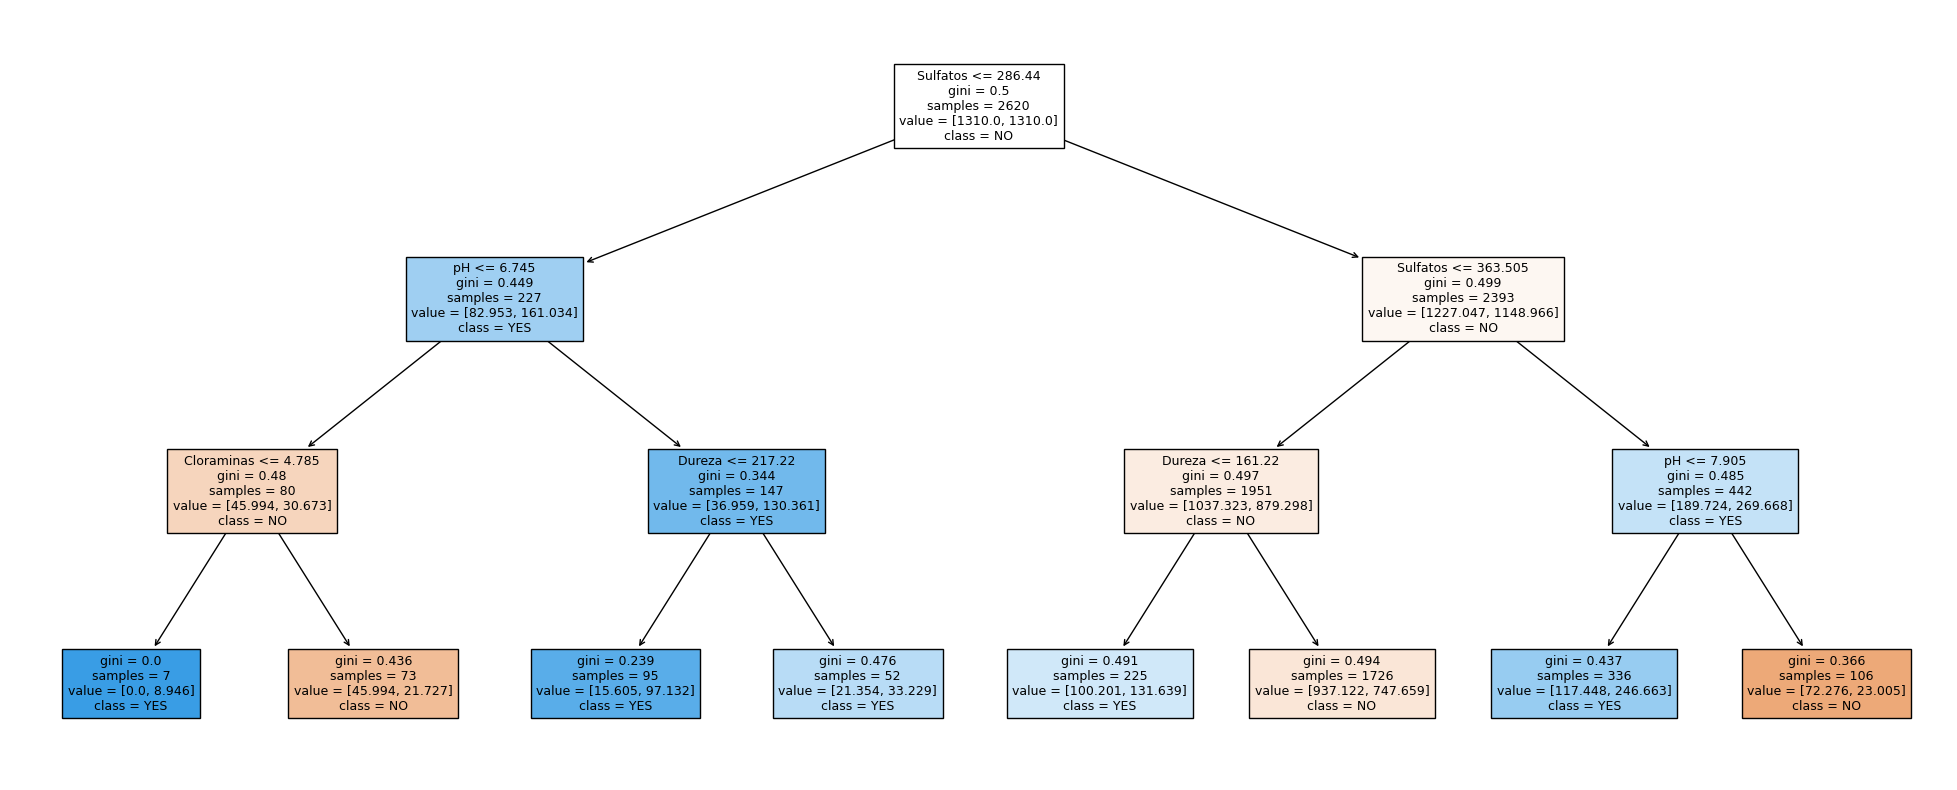

In [160]:
plt.figure(figsize=(25,10))
tree = plot_tree(final_model, feature_names=columns, class_names=['NO','YES'], filled=True, fontsize=9)

Del diagrama se pueden extraer las siguiente reglas para determinar cuándo el agua **NO es potable**:
- Si la concentración de **Sulfatos <= 286.44** y el **pH <= 6.745** y las **Cloraminas <= 4.785**, luego la muestra de agua tiene mayor probabilidad de ser no potable __en una relación de 46 a 21 (63%)__.
- Si la concentración de **Sulfatos > 286.44** pero **<= 363.5** y la **dureza <= 161.2**, luego la muestra de agua tiene mayor probabilidad de ser no potable __con una probabilidad del 54%__.
- Si la concentración de **Sulfatos > 363.5** y el **pH > 7.905**, luego la muestra de agua tiene mayor probabilidad de ser no potable __en una relación de 72 a 23__.

**Respuesta a las preguntas finales planteadas**

- ¿Qué puedes decir de los valores de las métricas recall y precisión para cada una de las clases en cada modelo? ¿Cuál de estás métricas consideras que es más importante con base en la descripción del problema?

*Debido a que el problema busca garantizar la disponibilidad de agua potable para la humanidad, consideraría que es más relevante la clase positiva ("SI"). En ese sentido, sería más relevante optimizar para la precisión, ya que indica que si un modelo predice que el agua es potable, en realidad será potable.*

*En este orden de ideas, el modelo de KNN tuvo mayor precisión para la clase positiva (60%) que el modelo de árbol de decisión (50%)*

- ¿Consideras que el rendimiento de los modelos es adecuado? Si no es así, ¿Cómo podrían mejorarse los resultados?

*No me parecen rendimientos adecuados, son bastante bajos, en particular para la clase positiva. Si nuestro objetivo es predecir esta clase, se podría intentar:*
    - *Mejorar la recolección de los datos y la representatividad de esta clase durante la recolección.*  - *Optimizar para la métrica de precisión durante el proceso de búsqueda de los mejores hiperparámetros*  - *Intentar con algoritmos más avanzados, aunque podría perderce el beneficio de la interpretabilidad de los resultados.*

- ¿Cuáles son las variables más significativas según el mejor modelo basado en árboles de decisión? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.

*El árbol de decisión de profundidad 3 muestra que las variables más significativas son, en orden descendente, pH, Sulfatos, dureza, y cloraminas.*
*Aunque el modelo puede mejorarse, estos primeros hallazgos permitirían poner especial atención en estas variables al momento de tomar muestras de agua. También, si hubieran limitaciones de presupuesto que permitiera analizar un conjunto limitado de características, deberían priorizarse estas cuatro.*

- Si los dos modelos proporcionan resultados similares en cuanto a las métricas de rendimiento ¿Cuál seleccionarías tomando en cuenta el contexto del problema?

*En mi concepto, se busca garantizar la disponibilidad de agua potable para la humanidad, consideraría que es más relevante la clase positiva ("SI"). En ese sentido, sería más relevante optimizar para la precisión, ya que indica que si un modelo predice que el agua es potable, en realidad será potable. Finalmente, el modelo con la mejor precisión para la clase positiva  es KNN.*

### Saving the model

In [58]:
##########################
# SAVE-LOAD using joblib #
##########################
import joblib

# save
joblib.dump(best_tree, "decision_tree_model.pkl") 


['decision_tree_model.pkl']

In [61]:
loaded_pipeline = joblib.load('decision_tree_model.pkl')
loaded_pipeline
# Check the imputation strategy
# temp_imputer = loaded_pipeline.named_steps['imputer']
# print(f"Imputation strategy: {temp_imputer.strategy}") 

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7,
                                                   8])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_split=5,
                                        random_state=77))])

In [70]:
x_test.loc[2133].to_dict()

{'pH': 7.13,
 'Dureza': 173.69,
 'Sólidos': 19309.57,
 'Cloraminas': 6.53,
 'Sulfatos': 372.54,
 'Conductividad': 295.39,
 'Carbono_orgánico': 7.27,
 'Trihalometanos': 88.79,
 'Turbidez': 3.4}

In [69]:
y_test.loc[2133]

'NO'